
# Mini Inflation Data Prep & Exploratory Data Analysis (EDA) using sample files

This tiny notebook runs end-to-end on the included sample files to demonstrate the pipeline used in the Inflation Dashboard.

**Includes:**
- Load **sample monthly FAOSTAT-like data** (`sample_data.csv`)
- Clean → aggregate to **annual** per country (AUS & NZL, 2001–2002)
- Map **ISO3 → Region** (continent)
- Quick **EDA plots** with `matplotlib` (histogram + line chart)
- Save outputs:
  - `country-year_mean.csv`
  - `sample_data/Inflation_2001.geojson` and `Inflation_2002.geojson`

*Generated: 2025-09-11*


## 0. Setup

# Input Data Setup

This notebook demonstrates a **mini pipeline** using a small dataset (2 countries × 2 years).  
The same code also works for the **full preprocessing pipeline** if you replace the inputs with full FAOSTAT and GeoJSON files.

---

**1. Download Inflation Data (CSV) from FAOSTAT**  
👉 https://www.fao.org/faostat/en/#data/CP  

- For the **mini demo** (this repo): we provide a sample file in `data_raw/sample_data.csv` (Australia + New Zealand, 2001–2002).  
- For the **full pipeline**: download with these settings:  
  - **Coding system**: `ISO3`  
  - **Countries**: `All Countries`  
  - **Items**: `Food price inflation`  
  - **Years**: `2001–2024`  
  - **Months**: `All`  
  - Save as CSV.

---

**2. Download GeoJSON Maps**  
👉 https://geojson-maps.kyd.au/  

- For the **mini demo**: we downloaded a reduced file (`custom.geo.json`) for Oceana which includes AUS + NZ.  
- For the **full pipeline**: select  
  - **Resolution**: `Medium resolution`  
  - **Regions**: `All`  

---

**3. Organize Input Files**  
- Save both files (CSV + GeoJSON) in a folder.  
- In this notebook, that folder is named **`data_raw/`**.  

---

**4. Choose an Output Folder**  
- Decide where processed files will be written.  
- In this notebook, the output folder is named **`sample_data/`**.  


In [1]:
# NOTE: If running on Colab, uncomment the following lines to clone the repo
# (Binder already clones the repo automatically, so you don't need this there)

# !git clone https://github.com/Soph231/Food_inflation_visualization.git
# Move into the mini sample folder
# %cd Food_inflation_visualization/preprocessing_mini_sample

# --- Ensure country_converter is available (for Region mapping) ---
try:
    import country_converter as coco
except ImportError:
    print("Installing missing dependency: country_converter ...")
    %pip install -q country_converter
    from IPython.display import clear_output
    clear_output(wait=True)
    import country_converter as coco

from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_RAW = Path("data_raw") # Folder containing your raw input files (replace if different)
DATA_OUT = Path("sample_data") # Folder where processed outputs will be saved (replace if different)
DATA_OUT.mkdir(parents=True, exist_ok=True)

FAO = DATA_RAW / "sample_data.csv" # Replace with your FAOSTAT inflation CSV (e.g., "FAOSTAT_data_2000-2025.csv")
GEO = DATA_RAW / "custom.geo.json" # Replace with your GeoJSON map file (e.g., "custom.geo.json")

print("Files present?")
print(" -", FAO, "->", FAO.exists())
print(" -", GEO, "->", GEO.exists())


Files present?
 - data_raw/sample_data.csv -> True
 - data_raw/custom.geo.json -> True


## 1. Load & Clean (Sample)

In [2]:
# --- Load the FAOSTAT CSV ---
df = pd.read_csv(FAO)

# --- Standardize column names we will use later ---
COL_ISO3, COL_AREA, COL_YEAR, COL_MONTH, COL_VALUE = (
    "Area Code (ISO3)",  # country code in ISO3 format
    "Area",              # country name
    "Year",              # year of observation
    "Months",            # month column (may be numbers or names)
    "Value"              # monthly inflation value
)

# --- Ensure Months are numeric (1–12) ---
# Some FAOSTAT files use month names ("Jan", "February"), others use numbers.
# This block converts everything into a clean integer month column.
if df[COL_MONTH].dtype == 'object':
    # map 3-letter month abbreviations (case-insensitive) to numbers
    month_map = {m.lower(): i for i, m in enumerate(
        ['Jan','Feb','Mar','Apr','May','Jun',
         'Jul','Aug','Sep','Oct','Nov','Dec'], start=1)}
    mnum = df[COL_MONTH].astype(str).str.strip().str[:3].str.lower().map(month_map)
    # fallback: if the string is actually a number, keep it
    df["Month_num"] = mnum.fillna(pd.to_numeric(df[COL_MONTH], errors="coerce"))
else:
    # if already numeric, just coerce
    df["Month_num"] = pd.to_numeric(df[COL_MONTH], errors="coerce")

# --- Convert columns to numeric types ---
df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors="coerce").astype("Int64")
df["Month_num"] = pd.to_numeric(df["Month_num"], errors="coerce").astype("Int64")
df[COL_VALUE] = pd.to_numeric(df[COL_VALUE], errors="coerce")

# --- Drop rows with missing critical fields ---
df = df.dropna(subset=[COL_AREA, COL_ISO3, COL_YEAR, "Month_num"])

# Quick check of cleaned data
df.head()


,Unnamed: 0,Domain Code,Domain,Area Code (ISO3),Area,Year Code,Year,Item Code,Item,Months Code,Months,Element Code,Element,Unit,Value,Flag,Flag Description,Note,Month_num
0,1848,CP,Consumer Price Indices,AUS,Australia,2001,2001,23014,Food price inflation,7001,January,6121,Value,%,4.605937,E,Estimated value,NaN,1
1,1849,CP,Consumer Price Indices,AUS,Australia,2001,2001,23014,Food price inflation,7002,February,6121,Value,%,5.677749,E,Estimated value,NaN,2
2,1850,CP,Consumer Price Indices,AUS,Australia,2001,2001,23014,Food price inflation,7003,March,6121,Value,%,6.748466,E,Estimated value,NaN,3
3,1851,CP,Consumer Price Indices,AUS,Australia,2001,2001,23014,Food price inflation,7004,April,6121,Value,%,6.727829,E,Estimated value,NaN,4
4,1852,CP,Consumer Price Indices,AUS,Australia,2001,2001,23014,Food price inflation,7005,May,6121,Value,%,6.707317,E,Estimated value,NaN,5


## 2. Aggregate to Annual

In [3]:
# --- Aggregate monthly data to annual averages ---
annual = (
    df.groupby([COL_ISO3, COL_AREA, COL_YEAR], as_index=False)
      .agg(
          Value=(COL_VALUE, "mean"),          # average inflation across months
          months_observed=(COL_VALUE, "count")  # how many months of data are present
      )
)

# --- Keep only countries/years with enough data ---
# Require at least 6 months of observations to compute a reliable annual mean
annual = annual[annual["months_observed"] >= 6].copy()

# --- Add cleaned columns ---
annual["Inflation"] = annual["Value"].round(1)  # round mean inflation to 1 decimal place
annual["Country"] = annual[COL_AREA]            # duplicate country name for clarity/consistency

# Quick look at the annual summary
annual


,Area Code (ISO3),Area,Year,Value,months_observed,Inflation,Country
0,AUS,Australia,2001,6.297070,12,6.3,Australia
1,AUS,Australia,2002,3.999850,12,4.0,Australia
2,NZL,New Zealand,2001,6.310640,12,6.3,New Zealand
3,NZL,New Zealand,2002,3.536724,12,3.5,New Zealand


## 3. Region Mapping (ISO3 → Continent)

In [4]:
# --- Map countries to regions (continents) using ISO3 codes ---
try:
    import country_converter as coco
    cc = coco.CountryConverter()
    
    # Convert ISO3 country codes → continent names
    annual["Region"] = cc.convert(
        names=annual[COL_ISO3],
        src="ISO3",
        to="continent",
        not_found=None   # if a code is not recognized, return None
    )
except Exception as e:
    # If the package is missing (e.g. on Colab/Binder) or conversion fails
    print("country_converter unavailable:", e)
    annual["Region"] = pd.NA  # fallback: column filled with missing values

# Quick check of Region assignment
annual


,Area Code (ISO3),Area,Year,Value,months_observed,Inflation,Country,Region
0,AUS,Australia,2001,6.297070,12,6.3,Australia,Oceania
1,AUS,Australia,2002,3.999850,12,4.0,Australia,Oceania
2,NZL,New Zealand,2001,6.310640,12,6.3,New Zealand,Oceania
3,NZL,New Zealand,2002,3.536724,12,3.5,New Zealand,Oceania


## 4. EDA Plots

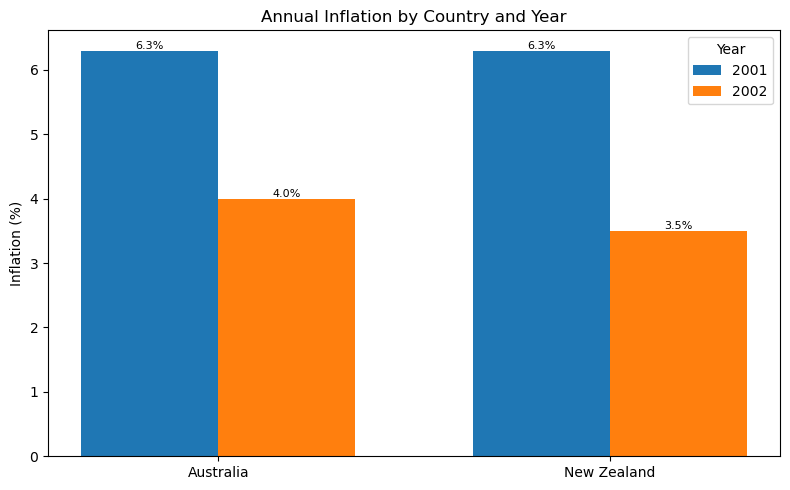

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare data for grouped bar chart ---
# We assume `annual` has at least these columns: Country, Year, Inflation
countries = annual["Country"].unique()          # unique country names
years = sorted(annual["Year"].unique())         # sorted list of years

x = np.arange(len(countries))                   # x-axis positions for countries
width = 0.35                                    # width of each bar (tune if >2 years shown)

# --- Create plot ---
plt.figure(figsize=(8, 5))

for i, y in enumerate(years):
    # Filter data for one year, indexed by Country
    subset = annual[annual["Year"] == y].set_index("Country")
    
    # Get inflation values for all countries (0 if missing)
    infl_vals = [subset.loc[c, "Inflation"] if c in subset.index else 0 
                 for c in countries]
    
    # Plot bars for this year, shifted by i*width
    bars = plt.bar(x + i*width, infl_vals, width, label=str(y))
    
    # --- Annotate bars with numeric labels ---
    for bar, val in zip(bars, infl_vals):
        plt.text(
            bar.get_x() + bar.get_width()/2,   # x-position (center of bar)
            bar.get_height(),                  # y-position (top of bar)
            f"{val:.1f}%",                     # label (e.g., "3.4%")
            ha="center", va="bottom", fontsize=8
        )

# --- Customize axes & layout ---
plt.xticks(x + width*(len(years)-1)/2, countries)  # center country labels
plt.ylabel("Inflation (%)")
plt.title("Annual Inflation by Country and Year")
plt.legend(title="Year")
plt.tight_layout()
plt.show()


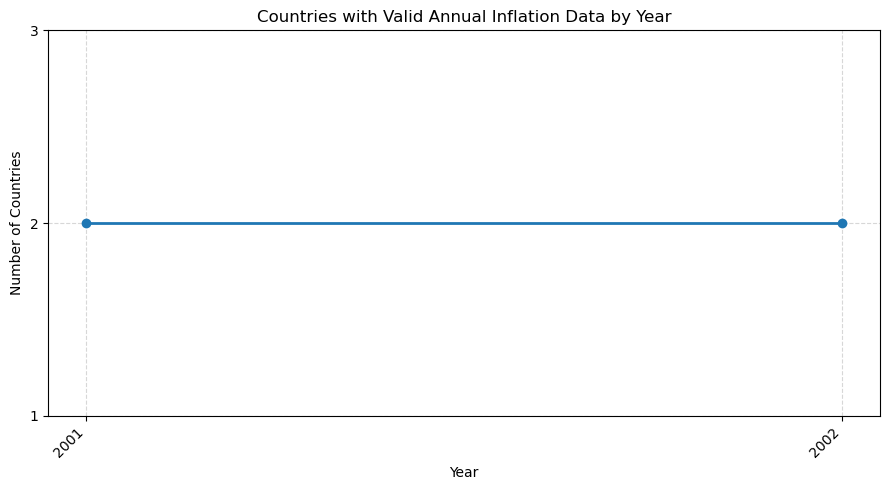

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --- Ensure Year is integer and compute coverage (countries per year) ---
# If `annual` already exists (country-year aggregated table), this will just work.
# It counts how many *distinct countries (ISO3)* have a valid annual record for each year.
annual["Year"] = annual["Year"].astype(int)
coverage = (annual
            .dropna(subset=[COL_ISO3, "Year"])       # keep valid keys
            .groupby("Year")[COL_ISO3]
            .nunique()                                # distinct countries per year
            .sort_index())

# --- Build the line chart ---
plt.figure(figsize=(9, 5))
plt.plot(coverage.index, coverage.values, marker="o", linewidth=2)

# --- Titles & labels ---
plt.title("Countries with Valid Annual Inflation Data by Year")
plt.xlabel("Year")
plt.ylabel("Number of Countries")

# --- Ticks & formatting (works well for many years) ---
# X-axis: show integer years (limit the number of ticks for long ranges)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=12))  # ~12 ticks max
plt.xticks(rotation=45, ha="right")                              # readable labels

# Y-axis: integer ticks only
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Optional: add a little padding so the line isn't glued to the top/bottom
ymin, ymax = coverage.min(), coverage.max()
plt.ylim(ymin - 1, ymax + 1)

# Visual polish
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## 5. Save Outputs

In [8]:

# Save annual CSV (clean version, no index)
# --- Ensure required columns exist before saving ---
#import pandas as pd

# 1) Country column (duplicate of Area)
if "Country" not in annual.columns:
    annual["Country"] = annual[COL_AREA]

# 2) Value column (mean before rounding)
# If it's missing but you do have Inflation (rounded mean), use that as a fallback
if "Value" not in annual.columns:
    if "Inflation" in annual.columns:
        annual["Value"] = annual["Inflation"]  # fallback for the mini demo
    else:
        # Recompute from the monthly df if necessary (last resort)
        annual = (df.groupby([COL_ISO3, COL_AREA, COL_YEAR], as_index=False)
                    .agg(Value=(COL_VALUE, "mean"),
                         months_observed=(COL_VALUE, "count")))
        annual["Inflation"] = annual["Value"].round(1)
        annual["Country"] = annual[COL_AREA]
        
# 2.1) categorize inflation
# --- Categorize inflation values ---
def categorize_inflation(val):
    if pd.isna(val):
        return None
    if val < 0:
        return "Deflation"
    elif val <= 2:
        return "Very Low Inflation"
    elif val <= 3:
        return "Target Inflation"
    elif val <= 4:
        return "Low Inflation"
    elif val <= 10:
        return "Moderate Inflation"
    elif val <=50:
        return "High Inflation"
    elif val <= 100:
        return "Very High Inflation"
    else:
        return "Hyperinflation"

annual["Inflation_Category"] = annual["Inflation"].apply(categorize_inflation)

# 3) Region column (continent via country_converter)
if "Region" not in annual.columns:
    try:
        import country_converter as coco
        cc = coco.CountryConverter()
        annual["Region"] = cc.convert(
            names=annual[COL_ISO3],
            src="ISO3",
            to="continent",
            not_found=None
        )
    except Exception as e:
        print("Region mapping skipped:", e)
        annual["Region"] = pd.NA

# --- Now save safely (only select existing columns) ---
cols = [COL_ISO3, COL_AREA, COL_YEAR, "Value", "Country", "Inflation", "Region", "Inflation_Category"]
cols_existing = [c for c in cols if c in annual.columns]

annual_csv = "country-year_mean.csv"
(annual[cols_existing]
 .sort_values([COL_ISO3, COL_YEAR])
 .to_csv(annual_csv, index=False))

print("Saved:", annual_csv)
# Build per-year GeoJSONs from the provided custom.geo.json
with open(GEO, "r", encoding="utf-8") as f:
    world = json.load(f)

def feature_iso3(props: dict):
    return (props.get("iso_a3")
            or props.get("iso_a3_eh")
            or props.get("ISO_A3")
            or props.get("adm0_a3")
            or props.get("ISO3")
            or props.get("iso3"))

for year in sorted(annual["Year"].unique()):
    yr = annual[annual["Year"] == year].set_index(COL_ISO3)
    out = {"type": world["type"], "features": []}
    for feat in world["features"]:
        props = dict(feat.get("properties", {}))
        iso3 = feature_iso3(props)
        new_props = dict(props)
        new_props["Year"] = int(year)

        if iso3 in yr.index:
            new_props["Inflation"] = float(yr.loc[iso3, "Inflation"])
            cat = None  # categories omitted in mini sample for brevity
            new_props["Inflation_Category"] = cat
        else:
            new_props["Inflation"] = None
            new_props["Inflation_Category"] = None

        out["features"].append({
            "type": feat.get("type", "Feature"),
            "geometry": feat.get("geometry"),
            "properties": new_props
        })

    out_path = DATA_OUT / f"Inflation_{int(year)}.geojson"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(out, f)

annual_csv, [p.name for p in DATA_OUT.glob("Inflation_*.geojson")]


Saved: country-year_mean.csv


('country-year_mean.csv', ['Inflation_2001.geojson', 'Inflation_2002.geojson'])

In [ ]:
# For Colab or Binder users: get a download link to download to your computer
import shutil
from IPython.display import FileLink

# Zip the sample_data folder
shutil.make_archive("sample_data", "zip", "sample_data")

# Show clickable download links in the notebook
display(FileLink("country-year_mean.csv"))
display(FileLink("sample_data.zip"))


## 6. Visualize inflation on a map

In [9]:
# --- Folium map using processed annual CSV with CATEGORY colors ---

# 0) deps
try:
    import folium
except ImportError:
    print("Installing folium ...")
    %pip install -q folium
    from IPython.display import clear_output
    clear_output(wait=True)
    import folium

import json
from IPython.display import IFrame, display

# Assumes: annual (with Area Code (ISO3), Year, Inflation, Inflation_Category)
#          COL_ISO3, GEO already defined earlier
YEAR = 2001

# 1) slice to chosen year & normalize ISO3
annual_y = annual.loc[annual["Year"] == YEAR, [COL_ISO3, "Inflation", "Inflation_Category"]].copy()
annual_y[COL_ISO3] = annual_y[COL_ISO3].astype(str).str.strip().str.upper()

# 2) load & normalize GeoJSON, then inject BOTH value + category
with open(GEO, "r", encoding="utf-8") as f:
    gj = json.load(f)

for feat in gj["features"]:
    props = feat.setdefault("properties", {})
    if props.get("iso_a3") is not None:
        props["iso_a3"] = str(props["iso_a3"]).strip().upper() if hasattr(props["iso_a3"], "upper") else str(props["iso_a3"]).strip().upper()

# build lookup dict: ISO3 -> {Inflation, Inflation_Category}
lut = annual_y.set_index(COL_ISO3)[["Inflation", "Inflation_Category"]].to_dict(orient="index")
for feat in gj["features"]:
    iso3 = feat["properties"].get("iso_a3")
    rec = lut.get(iso3, {})
    feat["properties"]["Inflation"] = rec.get("Inflation")
    feat["properties"]["Inflation_Category"] = rec.get("Inflation_Category")

# 3) category palette
cat_colors = {
    "Deflation": "#4575b4",
    "Low Inflation": "#91bfdb",
    "Target Inflation": "#e0f3f8",
    "Moderate Inflation": "#fee090",
    "High Inflation": "#fc8d59",
    "Very High Inflation": "#d73027",
    "Hyperinflation": "#7f0000",
}

# 4) build & style map
m = folium.Map(location=[-20, 150], zoom_start=3, tiles="cartodbpositron")  # adjust for world: [20,0],2

folium.GeoJson(
    gj,
    name=f"Inflation Categories {YEAR}",
    style_function=lambda feat: {
        "fillColor": cat_colors.get(feat["properties"].get("Inflation_Category"), "#cccccc"),
        "color": "white",
        "weight": 0.5,
        "fillOpacity": 0.9,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "iso_a3", "Inflation", "Inflation_Category"],
        aliases=["Country", "ISO3", "Inflation %", "Category"],
        localize=True
    ),
).add_to(m)

folium.LayerControl().add_to(m)

# 5) save + embed (don’t return `m` directly to avoid UI hiccups)
out_html = f"annual_map_{YEAR}.html"
m.save(out_html)
display(IFrame(out_html, width="100%", height=550))


In [11]:
# --- Category-colored map from per-year GeoJSON (no CSV needed) ---

from pathlib import Path
import json

# Ensure folium
try:
    import folium
except ImportError:
    %pip install -q folium
    from IPython.display import clear_output; clear_output(wait=True)
    import folium

from IPython.display import IFrame, display

YEAR = 2002
GJ_PATH = Path("sample_data") / f"Inflation_{YEAR}.geojson"  # adjust if your outputs folder differs

# Load the per-year GeoJSON saved by your pipeline
with open(GJ_PATH, "r", encoding="utf-8") as f:
    gj = json.load(f)

# --- Derive Inflation_Category from Inflation (if missing) ---
def categorize(val):
    if val is None:
        return None
    try:
        x = float(val)
    except Exception:
        return None
    if x < 0:   return "Deflation"
    if x <= 2:   return "Very Low Inflation"
    if x <= 3:   return "Target Inflation"
    if x <= 4:   return "Low Inflation"
    if x <= 10:   return "Moderate Inflation"
    if x <= 50:  return "High Inflation"
    if x <= 100:  return "Very High Inflation"
    return "Hyperinflation"

# Normalize ISO3 (helps future joins/consistency) and inject category
for feat in gj.get("features", []):
    props = feat.setdefault("properties", {})
    # normalize ISO3 key if present
    for k in ("iso_a3", "ISO_A3", "adm0_a3", "ADM0_A3", "ISO3", "iso3"):
        if k in props and props[k] is not None:
            props[k] = str(props[k]).strip().upper()
            # store a canonical key for convenience
            props.setdefault("iso_a3", props[k])

    # compute category from existing Inflation value
    infl = props.get("Inflation")
    props["Inflation_Category"] = props.get("Inflation_Category") or categorize(infl)

# Fixed palette per category
cat_colors = {
    "Deflation":        "#4575b4",
    "Low Inflation":    "#91bfdb",
    "Target Inflation": "#e0f3f8",
    "Moderate Inflation":"#fee090",
    "High Inflation":   "#fc8d59",
    "Very High Inflation":"#d73027",
    "Hyperinflation":   "#7f0000",
}

# Build the map (world view; for AUS/NZ use location=[-20,150], zoom_start=3)
m = folium.Map(location=[20, 0], zoom_start=2, tiles="cartodbpositron")

# Style polygons by the category we just derived
folium.GeoJson(
    gj,
    name=f"Inflation Categories {YEAR}",
    style_function=lambda feat: {
        "fillColor": cat_colors.get(feat["properties"].get("Inflation_Category"), "#cccccc"),
        "color": "white",
        "weight": 0.5,
        "fillOpacity": 0.9,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "iso_a3", "Inflation", "Inflation_Category"],
        aliases=["Country", "ISO3", "Inflation %", "Category"],
        localize=True
    ),
).add_to(m)

folium.LayerControl().add_to(m)

# Save + embed (safer than returning m directly)
out_html = f"annual_map_{YEAR}.html"
m.save(out_html)
display(IFrame(out_html, width="100%", height=550))


In [ ]:
'''
# --- Save outputs before session ends ---
# For Colab users: download to your computer
from google.colab import files
import shutil

# Zip all outputs into one file
shutil.make_archive("sample_data", "zip", "sample_data")

# Download CSV + zipped GeoJSONs
files.download("country-year_mean.csv")
files.download("sample_data.zip")

# or get clickable download links on the notebook
import shutil
from IPython.display import FileLink

# Zip the sample_data folder
shutil.make_archive("sample_data", "zip", "sample_data")

# Show clickable download links in the notebook
display(FileLink("country-year_mean.csv"))
display(FileLink("sample_data.zip"))
'''